# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = 'rainfall'
    n_folds = 10
    seed = 2100
    time_limit = 3600 * 11

    pipeline = 4

# Loading data and predefining folds

In [3]:
def get_data(pipeline):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")

    test.winddirection = test.winddirection.fillna(test.winddirection.median())
    
    if pipeline == 1:
        return train, test, None
    
    original = pd.read_csv(CFG.original_path, encoding="gbk")
    original["date"] = pd.to_datetime(original[["year", "month", "day"]])
    original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
    original["day"] = original.date.dt.dayofyear
    original = original.drop("date", axis=1)
    original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
    original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
    original.sunshine = original.sunshine.replace('-', 0).astype(float)
    original.windspeed = original.windspeed.fillna(original.windspeed.mean())
    for col in original.columns:
        original[col] = original[col].astype(train[col].dtype)
        
    if pipeline == 2:
        return train, test, original
        
    original_2 = pd.read_csv(CFG.original_path_2)
    original_2.columns = original_2.columns.str.replace(" ", "")
    original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
    original_2.winddirection = original_2.winddirection.fillna(original_2.winddirection.mean())
    original_2.windspeed = original_2.windspeed.fillna(original_2.windspeed.mean())
    original_2.day = original_2.index + 1
    for col in original_2.columns:
        original_2[col] = original_2[col].astype(train[col].dtype)
        
    if pipeline == 3:
        return train, test, original_2
        
    original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
    original_combined = original_combined.drop_duplicates().reset_index(drop=True)

    return train, test, original_combined

In [4]:
train, test, original = get_data(CFG.pipeline)

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [7]:
if original is None:
    predictor.fit(
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )
else:
    predictor.fit_pseudolabel(
        pseudo_data=original,
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.19 GB / 31.35 GB (96.3%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the

(_ray_fit pid=7377) [1000]	valid_set's binary_logloss: 0.303317
(_ray_fit pid=7525) [1000]	valid_set's binary_logloss: 0.346226 [repeated 8x across cluster]


(_dystack pid=168) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.76s	 = Training   runtime
(_dystack pid=168) 	0.26s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 6189.29s of the 9489.71s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=168) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=168) 	35.12s	 = Training   runtime
(_dystack pid=168) 	0.14s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 6151.29s of the 9451.71s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.12%)
(_dystack pid=168) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.39s	 = Training   runtime
(_dystack pid

(_ray_fit pid=17306) [1000]	valid_set's binary_logloss: 0.312991 [repeated 3x across cluster]
(_ray_fit pid=17437) [1000]	valid_set's binary_logloss: 0.349358 [repeated 7x across cluster]
(_ray_fit pid=17566) [1000]	valid_set's binary_logloss: 0.294934 [repeated 3x across cluster]


(_dystack pid=168) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=168) 	19.08s	 = Training   runtime
(_dystack pid=168) 	0.54s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 5464.57s of the 8764.99s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=168) 	0.8823	 = Validation score   (roc_auc)
(_dystack pid=168) 	17.83s	 = Training   runtime
(_dystack pid=168) 	1.0s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 5443.78s of the 8744.20s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=168) 	0.8944	 = Validation sc

(_ray_fit pid=24173) [1000]	valid_set's binary_logloss: 0.294527 [repeated 5x across cluster]


(_dystack pid=168) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.53s	 = Training   runtime
(_dystack pid=168) 	0.1s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r143_BAG_L1 ... Training model for up to 4951.72s of the 8252.15s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=168) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=168) 	45.5s	 = Training   runtime
(_dystack pid=168) 	0.13s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r128_BAG_L1 ... Training model for up to 4903.17s of the 8203.60s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=168) 	0.8928	 = Validation score   (roc_auc)
(_dystack pid=168) 	33.14s	 = Training   runtime
(_dystack pi

(_ray_fit pid=27498) [1000]	valid_set's binary_logloss: 0.304081
(_ray_fit pid=27500) [1000]	valid_set's binary_logloss: 0.296375
(_ray_fit pid=27766) [1000]	valid_set's binary_logloss: 0.317417


(_dystack pid=168) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.7s	 = Training   runtime
(_dystack pid=168) 	0.22s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r49_BAG_L1 ... Training model for up to 4689.54s of the 7989.96s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=168) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=168) 	9.71s	 = Training   runtime
(_dystack pid=168) 	0.09s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r5_BAG_L1 ... Training model for up to 4677.07s of the 7977.49s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=168) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=168) 	11.77s	 = Training   runtime
(_dystack pid=168) 	0.

(_ray_fit pid=50624) [1000]	valid_set's binary_logloss: 0.272771
(_ray_fit pid=50624) [2000]	valid_set's binary_logloss: 0.272125
(_ray_fit pid=50624) [3000]	valid_set's binary_logloss: 0.270808
(_ray_fit pid=50624) [4000]	valid_set's binary_logloss: 0.270575
(_ray_fit pid=50752) [1000]	valid_set's binary_logloss: 0.336464


(_dystack pid=168) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.12s	 = Training   runtime
(_dystack pid=168) 	0.16s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 6422.15s of the 6421.90s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=168) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=168) 	43.12s	 = Training   runtime
(_dystack pid=168) 	0.27s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 6375.78s of the 6375.54s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.24%)
(_dystack pid=168) 	0.9021	 = Validation score   (roc_auc)
(_dystack pid=168) 	17.08s	 = Training   runtime
(_dystack pid

(autoscaler +59m24s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +59m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9039	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.1s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r102_BAG_L2 ... Training model for up to 6323.00s of the 6322.75s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +59m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=168) 	64.6s	 = Training   runtime
(_dystack pid=168) 	0.4s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r13_BAG_L2 ... Training model for up to 6255.41s of the 6255.17s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h1m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9037	 = Validation score   (roc_auc)
(_dystack pid=168) 	57.09s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r195_BAG_L2 ... Training model for up to 6195.13s of the 6194.89s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h1m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.896	 = Validation score   (roc_auc)
(_dystack pid=168) 	32.51s	 = Training   runtime
(_dystack pid=168) 	1.11s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r188_BAG_L2 ... Training model for up to 6159.71s of the 6159.47s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h2m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.33s	 = Training   runtime
(_dystack pid=168) 	0.06s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r145_BAG_L2 ... Training model for up to 6142.42s of the 6142.18s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=54171) No improvement since epoch 9: early stopping
(_ray_fit pid=54359) No improvement since epoch 9: early stopping
(_ray_fit pid=54545) No improvement since epoch 10: early stopping
(_dystack pid=168) 	0.9022	 = Validation score   (roc_auc)
(_dystack pid=168) 	36.32s	 = Training   runtime
(_dystack pid=168) 	0.25s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r89_BAG_L2 ... Training model for up to 6103.07s of the 6102.83s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with Par

(autoscaler +1h3m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=168) 	9.22s	 = Training   runtime
(_dystack pid=168) 	0.06s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r30_BAG_L2 ... Training model for up to 6090.62s of the 6090.38s of remaining time.
(_ray_fit pid=54542) No improvement since epoch 10: early stopping
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h3m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.898	 = Validation score   (roc_auc)
(_dystack pid=168) 	83.42s	 = Training   runtime
(_dystack pid=168) 	0.29s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r130_BAG_L2 ... Training model for up to 6004.38s of the 6004.14s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.23%)


(autoscaler +1h5m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=168) 	13.88s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r86_BAG_L2 ... Training model for up to 5987.58s of the 5987.33s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h5m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=168) 	33.84s	 = Training   runtime
(_dystack pid=168) 	0.28s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r50_BAG_L2 ... Training model for up to 5950.41s of the 5950.17s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=168) 	0.9066	 = Validation score   (roc_auc)
(_dystack pid=168) 	18.19s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r11_BAG_L2 ... Training model for up to 5929.29s of the 5929.04s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h6m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=56646) No improvement since epoch 1: early stopping
(_dystack pid=168) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=168) 	43.94s	 = Training   runtime
(_dystack pid=168) 	0.22s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r194_BAG_L2 ... Training model for up to 5882.39s of the 5882.15s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_ray_fit pid=56643) No improvement since epoch 10: early stopping


(autoscaler +1h7m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8986	 = Validation score   (roc_auc)
(_dystack pid=168) 	10.51s	 = Training   runtime
(_dystack pid=168) 	0.1s	 = Validation runtime
(_dystack pid=168) Fitting model: ExtraTrees_r172_BAG_L2 ... Training model for up to 5868.72s of the 5868.47s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=168) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.16s	 = Training   runtime
(_dystack pid=168) 	0.86s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r69_BAG_L2 ... Training model for up to 5853.57s of the 5853.33s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h7m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9041	 = Validation score   (roc_auc)
(_dystack pid=168) 	15.63s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r103_BAG_L2 ... Training model for up to 5835.08s of the 5834.84s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=58078) No improvement since epoch 17: early stopping


(autoscaler +1h8m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=58266) No improvement since epoch 13: early stopping [repeated 2x across cluster]
(_ray_fit pid=58452) No improvement since epoch 16: early stopping [repeated 2x across cluster]
(_dystack pid=168) 	0.8992	 = Validation score   (roc_auc)
(_dystack pid=168) 	31.19s	 = Training   runtime
(_dystack pid=168) 	0.16s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r14_BAG_L2 ... Training model for up to 5801.01s of the 5800.76s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=168) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=168) 	27.44s	 = Training   runtime
(_dystack pid=168) 	0.28s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r161_BAG_L2 ... Training model for up to 5770.49s of the 5770.24s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with Paralle

(autoscaler +1h8m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=168) 	21.97s	 = Training   runtime
(_dystack pid=168) 	0.1s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r143_BAG_L2 ... Training model for up to 5745.36s of the 5745.12s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h9m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8959	 = Validation score   (roc_auc)
(_dystack pid=168) 	23.83s	 = Training   runtime
(_dystack pid=168) 	0.19s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r70_BAG_L2 ... Training model for up to 5718.66s of the 5718.42s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +1h10m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9054	 = Validation score   (roc_auc)
(_dystack pid=168) 	38.92s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r156_BAG_L2 ... Training model for up to 5676.52s of the 5676.28s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h10m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60114) No improvement since epoch 3: early stopping
(_ray_fit pid=60116) No improvement since epoch 21: early stopping
(_ray_fit pid=60117) No improvement since epoch 23: early stopping
(_ray_fit pid=60299) No improvement since epoch 10: early stopping


(autoscaler +1h11m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60348) No improvement since epoch 5: early stopping
(_ray_fit pid=60519) No improvement since epoch 13: early stopping [repeated 3x across cluster]
(_dystack pid=168) 	0.8993	 = Validation score   (roc_auc)
(_dystack pid=168) 	70.86s	 = Training   runtime
(_dystack pid=168) 	0.31s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r196_BAG_L2 ... Training model for up to 5602.77s of the 5602.52s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.34%)


(_ray_fit pid=60585) [1000]	valid_set's binary_logloss: 0.275115
(autoscaler +1h11m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=60715) [1000]	valid_set's binary_logloss: 0.337676 [repeated 4x across cluster]
(_ray_fit pid=60849) [1000]	valid_set's binary_logloss: 0.286556
(_ray_fit pid=60855) [1000]	valid_set's binary_logloss: 0.32237


(_dystack pid=168) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=168) 	19.71s	 = Training   runtime
(_dystack pid=168) 	0.35s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 5579.87s of the 5579.63s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h12m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8971	 = Validation score   (roc_auc)
(_dystack pid=168) 	31.12s	 = Training   runtime
(_dystack pid=168) 	1.22s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 5545.71s of the 5545.46s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)
(_dystack pid=168) 	0.9032	 = Validation score   (roc_auc)
(_dystack pid=168) 	26.19s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r95_BAG_L2 ... Training model for up to 5516.73s of the 5516.49s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h13m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=61970) No improvement since epoch 10: early stopping
(_ray_fit pid=62182) No improvement since epoch 9: early stopping [repeated 2x across cluster]
(_dystack pid=168) 	0.899	 = Validation score   (roc_auc)
(_dystack pid=168) 	38.7s	 = Training   runtime
(_dystack pid=168) 	0.22s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r41_BAG_L2 ... Training model for up to 5474.99s of the 5474.75s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h13m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=168) 	37.38s	 = Training   runtime
(_dystack pid=168) 	0.3s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r98_BAG_L2 ... Training model for up to 5434.35s of the 5434.11s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h14m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9024	 = Validation score   (roc_auc)
(_dystack pid=168) 	19.6s	 = Training   runtime
(_dystack pid=168) 	0.14s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r15_BAG_L2 ... Training model for up to 5411.77s of the 5411.53s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.07%)
(_dystack pid=168) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=168) 	15.26s	 = Training   runtime
(_dystack pid=168) 	0.07s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r158_BAG_L2 ... Training model for up to 5393.59s of the 5393.34s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h15m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8938	 = Validation score   (roc_auc)
(_dystack pid=168) 	93.45s	 = Training   runtime
(_dystack pid=168) 	0.32s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r86_BAG_L2 ... Training model for up to 5296.99s of the 5296.75s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +1h16m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=168) 	47.62s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r37_BAG_L2 ... Training model for up to 5246.42s of the 5246.17s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h17m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=64228) No improvement since epoch 18: early stopping
(_dystack pid=168) 	0.8999	 = Validation score   (roc_auc)
(_dystack pid=168) 	29.28s	 = Training   runtime
(_dystack pid=168) 	0.14s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r197_BAG_L2 ... Training model for up to 5214.35s of the 5214.11s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h18m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9024	 = Validation score   (roc_auc)
(_dystack pid=168) 	24.6s	 = Training   runtime
(_dystack pid=168) 	0.27s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r49_BAG_L2 ... Training model for up to 5186.42s of the 5186.18s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h18m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.18s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: ExtraTrees_r49_BAG_L2 ... Training model for up to 5168.98s of the 5168.73s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=168) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=168) 	13.15s	 = Training   runtime
(_dystack pid=168) 	0.92s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r143_BAG_L2 ... Training model for up to 5152.83s of the 5152.58s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.44%)


(autoscaler +1h19m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=168) 	19.67s	 = Training   runtime
(_dystack pid=168) 	0.09s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r127_BAG_L2 ... Training model for up to 5130.30s of the 5130.06s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h19m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8979	 = Validation score   (roc_auc)
(_dystack pid=168) 	35.51s	 = Training   runtime
(_dystack pid=168) 	0.97s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r134_BAG_L2 ... Training model for up to 5091.66s of the 5091.41s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h20m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66538) No improvement since epoch 11: early stopping
(_ray_fit pid=66537) No improvement since epoch 22: early stopping


(autoscaler +1h21m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h21m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66798) No improvement since epoch 17: early stopping
(_ray_fit pid=66907) No improvement since epoch 25: early stopping
(_dystack pid=168) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=168) 	129.94s	 = Training   runtime
(_dystack pid=168) 	0.42s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r34_BAG_L2 ... Training model for up to 4958.82s of the 4958.58s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h22m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=168) 	20.26s	 = Training   runtime
(_dystack pid=168) 	1.02s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r94_BAG_L2 ... Training model for up to 4935.54s of the 4935.29s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(_ray_fit pid=67598) [1000]	valid_set's binary_logloss: 0.33728


(_dystack pid=168) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.99s	 = Training   runtime
(_dystack pid=168) 	0.06s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r143_BAG_L2 ... Training model for up to 4919.63s of the 4919.38s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h23m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h23m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=168) 	79.06s	 = Training   runtime
(_dystack pid=168) 	0.29s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r128_BAG_L2 ... Training model for up to 4837.43s of the 4837.19s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +1h24m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h25m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=168) 	75.34s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r111_BAG_L2 ... Training model for up to 4759.15s of the 4758.91s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h25m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h26m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.903	 = Validation score   (roc_auc)
(_dystack pid=168) 	57.32s	 = Training   runtime
(_dystack pid=168) 	0.38s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r31_BAG_L2 ... Training model for up to 4698.97s of the 4698.73s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h26m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=168) 	35.61s	 = Training   runtime
(_dystack pid=168) 	0.25s	 = Validation runtime
(_dystack pid=168) Fitting model: ExtraTrees_r4_BAG_L2 ... Training model for up to 4660.07s of the 4659.83s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h27m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.7s	 = Training   runtime
(_dystack pid=168) 	0.91s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r65_BAG_L2 ... Training model for up to 4644.41s of the 4644.17s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=168) 	0.8908	 = Validation score   (roc_auc)
(_dystack pid=168) 	23.38s	 = Training   runtime
(_dystack pid=168) 	0.19s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r88_BAG_L2 ... Training model for up to 4618.07s of the 4617.83s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h28m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=70333) No improvement since epoch 25: early stopping
(_ray_fit pid=70513) No improvement since epoch 1: early stopping [repeated 3x across cluster]
(_dystack pid=168) 	0.8662	 = Validation score   (roc_auc)
(_dystack pid=168) 	23.21s	 = Training   runtime
(_dystack pid=168) 	0.14s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r30_BAG_L2 ... Training model for up to 4591.49s of the 4591.24s of remaining time.
(_ray_fit pid=70610) No improvement since epoch 1: early stopping [repeated 2x across cluster]
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.29%)


(_ray_fit pid=70799) [1000]	valid_set's binary_logloss: 0.267845
(_ray_fit pid=70799) [2000]	valid_set's binary_logloss: 0.264825
(autoscaler +1h28m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=70929) [1000]	valid_set's binary_logloss: 0.335016


(_dystack pid=168) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=168) 	16.73s	 = Training   runtime
(_dystack pid=168) 	0.26s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r49_BAG_L2 ... Training model for up to 4571.55s of the 4571.31s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_dystack pid=168) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=168) 	11.64s	 = Training   runtime
(_dystack pid=168) 	0.07s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r5_BAG_L2 ... Training model for up to 4556.99s of the 4556.74s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=168) 	0.9035	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.07s	 = Training   runtime
(_dystack pid=168) 	

(autoscaler +1h29m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9012	 = Validation score   (roc_auc)
(_dystack pid=168) 	35.08s	 = Training   runtime
(_dystack pid=168) 	0.27s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r71_BAG_L2 ... Training model for up to 4502.13s of the 4501.89s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h30m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=168) 	26.88s	 = Training   runtime
(_dystack pid=168) 	0.27s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r143_BAG_L2 ... Training model for up to 4472.31s of the 4472.06s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h30m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=168) 	25.91s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: ExtraTrees_r178_BAG_L2 ... Training model for up to 4443.57s of the 4443.33s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=168) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=168) 	13.6s	 = Training   runtime
(_dystack pid=168) 	0.77s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r166_BAG_L2 ... Training model for up to 4427.00s of the 4426.76s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 work

(autoscaler +1h31m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8968	 = Validation score   (roc_auc)
(_dystack pid=168) 	18.95s	 = Training   runtime
(_dystack pid=168) 	0.95s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r31_BAG_L2 ... Training model for up to 4405.09s of the 4404.85s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=168) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.17s	 = Training   runtime
(_dystack pid=168) 	0.12s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r185_BAG_L2 ... Training model for up to 4390.04s of the 4389.80s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h31m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=168) 	35.8s	 = Training   runtime
(_dystack pid=168) 	0.3s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r160_BAG_L2 ... Training model for up to 4351.30s of the 4351.06s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h32m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=168) 	30.74s	 = Training   runtime
(_dystack pid=168) 	0.22s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r60_BAG_L2 ... Training model for up to 4317.65s of the 4317.41s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h33m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9061	 = Validation score   (roc_auc)
(_dystack pid=168) 	15.87s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r15_BAG_L2 ... Training model for up to 4298.78s of the 4298.54s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h33m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=168) 	30.39s	 = Training   runtime
(_dystack pid=168) 	1.01s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r135_BAG_L2 ... Training model for up to 4265.33s of the 4265.08s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.51%)
(_dystack pid=168) 	0.9018	 = Validation score   (roc_auc)
(_dystack pid=168) 	15.09s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r22_BAG_L2 ... Training model for up to 4247.33s of the 4247.08s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +1h34m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=168) 	9.37s	 = Training   runtime
(_dystack pid=168) 	0.08s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r69_BAG_L2 ... Training model for up to 4234.92s of the 4234.68s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=168) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=168) 	30.35s	 = Training   runtime
(_dystack pid=168) 	0.19s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r6_BAG_L2 ... Training model for up to 4201.68s of the 4201.43s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h35m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9062	 = Validation score   (roc_auc)
(_dystack pid=168) 	18.4s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r138_BAG_L2 ... Training model for up to 4180.17s of the 4179.93s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=77449) No improvement since epoch 10: early stopping


(autoscaler +1h35m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=77452) No improvement since epoch 22: early stopping [repeated 3x across cluster]
(_ray_fit pid=77637) No improvement since epoch 8: early stopping
(_ray_fit pid=77635) No improvement since epoch 10: early stopping
(_ray_fit pid=77697) No improvement since epoch 23: early stopping [repeated 2x across cluster]
(_ray_fit pid=77853) No improvement since epoch 10: early stopping
(_dystack pid=168) 	0.8948	 = Validation score   (roc_auc)
(_dystack pid=168) 	47.06s	 = Training   runtime
(_dystack pid=168) 	0.24s	 = Validation runtime
(_ray_fit pid=77821) No improvement since epoch 11: early stopping
(_dystack pid=168) Fitting model: LightGBM_r121_BAG_L2 ... Training model for up to 4130.30s of the 4130.06s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.53%)


(autoscaler +1h36m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=168) 	22.73s	 = Training   runtime
(_dystack pid=168) 	0.13s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r172_BAG_L2 ... Training model for up to 4104.10s of the 4103.86s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h36m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=78441) No improvement since epoch 11: early stopping
(_dystack pid=168) 	0.8982	 = Validation score   (roc_auc)
(_dystack pid=168) 	24.94s	 = Training   runtime
(_dystack pid=168) 	0.27s	 = Validation runtime
(_ray_fit pid=78438) No improvement since epoch 11: early stopping [repeated 2x across cluster]
(_dystack pid=168) Fitting model: CatBoost_r180_BAG_L2 ... Training model for up to 4076.08s of the 4075.83s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +1h37m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9068	 = Validation score   (roc_auc)
(_dystack pid=168) 	54.66s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r76_BAG_L2 ... Training model for up to 4018.21s of the 4017.96s of remaining time.
(_ray_fit pid=78628) No improvement since epoch 11: early stopping
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h38m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=168) 	26.15s	 = Training   runtime
(_dystack pid=168) 	0.26s	 = Validation runtime
(_dystack pid=168) Fitting model: ExtraTrees_r197_BAG_L2 ... Training model for up to 3989.11s of the 3988.86s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h38m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=168) 	16.43s	 = Training   runtime
(_dystack pid=168) 	0.84s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r121_BAG_L2 ... Training model for up to 3969.50s of the 3969.26s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h39m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=168) 	68.37s	 = Training   runtime
(_dystack pid=168) 	0.29s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r127_BAG_L2 ... Training model for up to 3898.16s of the 3897.91s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h40m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=168) 	21.53s	 = Training   runtime
(_dystack pid=168) 	0.15s	 = Validation runtime
(_dystack pid=168) Fitting model: RandomForest_r16_BAG_L2 ... Training model for up to 3873.26s of the 3873.02s of remaining time.
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h40m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8946	 = Validation score   (roc_auc)
(_dystack pid=168) 	43.91s	 = Training   runtime
(_dystack pid=168) 	1.01s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r194_BAG_L2 ... Training model for up to 3826.03s of the 3825.79s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h41m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8942	 = Validation score   (roc_auc)
(_dystack pid=168) 	26.71s	 = Training   runtime
(_dystack pid=168) 	0.16s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r12_BAG_L2 ... Training model for up to 3796.39s of the 3796.15s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +1h41m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=168) 	35.93s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r135_BAG_L2 ... Training model for up to 3757.40s of the 3757.15s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h42m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=168) 	51.41s	 = Training   runtime
(_dystack pid=168) 	0.29s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r4_BAG_L2 ... Training model for up to 3703.08s of the 3702.84s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h43m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=82465) No improvement since epoch 18: early stopping
(_ray_fit pid=82652) No improvement since epoch 4: early stopping [repeated 2x across cluster]
(_dystack pid=168) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=168) 	26.6s	 = Training   runtime
(_dystack pid=168) 	0.13s	 = Validation runtime
(_dystack pid=168) Fitting model: ExtraTrees_r126_BAG_L2 ... Training model for up to 3673.28s of the 3673.04s of remaining time.
(_ray_fit pid=82648) No improvement since epoch 18: early stopping [repeated 3x across cluster]
(_dystack pid=168) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h43m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=168) 	13.28s	 = Training   runtime
(_dystack pid=168) 	1.02s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r36_BAG_L2 ... Training model for up to 3656.53s of the 3656.28s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h44m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=168) 	40.53s	 = Training   runtime
(_dystack pid=168) 	0.28s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r100_BAG_L2 ... Training model for up to 3613.08s of the 3612.83s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h45m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83761) No improvement since epoch 11: early stopping


(autoscaler +1h45m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83943) No improvement since epoch 11: early stopping
(_ray_fit pid=83976) No improvement since epoch 9: early stopping
(_ray_fit pid=84162) No improvement since epoch 9: early stopping [repeated 2x across cluster]
(_dystack pid=168) 	0.8927	 = Validation score   (roc_auc)
(_dystack pid=168) 	104.38s	 = Training   runtime
(_dystack pid=168) 	0.4s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r163_BAG_L2 ... Training model for up to 3505.40s of the 3505.16s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h46m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=168) 	14.47s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: CatBoost_r198_BAG_L2 ... Training model for up to 3488.06s of the 3487.82s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)
(_dystack pid=168) 	0.9045	 = Validation score   (roc_auc)
(_dystack pid=168) 	21.97s	 = Training   runtime
(_dystack pid=168) 	0.05s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetFastAI_r187_BAG_L2 ... Training model for up to 3463.20s of the 3462.95s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h47m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=168) 	24.23s	 = Training   runtime
(_dystack pid=168) 	0.12s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r19_BAG_L2 ... Training model for up to 3436.14s of the 3435.90s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h47m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=168) 	26.99s	 = Training   runtime
(_dystack pid=168) 	0.26s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r95_BAG_L2 ... Training model for up to 3405.83s of the 3405.59s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=168) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=168) 	9.64s	 = Training   runtime
(_dystack pid=168) 	0.09s	 = Validation runtime
(_dystack pid=168) Fitting model: XGBoost_r34_BAG_L2 ... Training model for up to 3393.21s of the 3392.97s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.23%)


(autoscaler +1h48m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=168) 	12.0s	 = Training   runtime
(_dystack pid=168) 	0.08s	 = Validation runtime
(_dystack pid=168) Fitting model: LightGBM_r42_BAG_L2 ... Training model for up to 3378.27s of the 3378.03s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.49%)
(_dystack pid=168) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=168) 	13.1s	 = Training   runtime
(_dystack pid=168) 	0.04s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r1_BAG_L2 ... Training model for up to 3361.83s of the 3361.59s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h49m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=168) 	42.98s	 = Training   runtime
(_dystack pid=168) 	0.33s	 = Validation runtime
(_dystack pid=168) Fitting model: NeuralNetTorch_r89_BAG_L2 ... Training model for up to 3315.75s of the 3315.51s of remaining time.
(_dystack pid=168) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h49m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=168) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=168) 	40.63s	 = Training   runtime
(_dystack pid=168) 	0.25s	 = Validation runtime
(_dystack pid=168) Fitting model: WeightedEnsemble_L3 ... Training model for up to 688.34s of the 3271.94s of remaining time.
(_dystack pid=168) 	Ensemble Weights: {'XGBoost_r89_BAG_L2': 0.208, 'CatBoost_r180_BAG_L2': 0.208, 'NeuralNetTorch_r135_BAG_L2': 0.208, 'NeuralNetFastAI_r102_BAG_L2': 0.167, 'NeuralNetTorch_r41_BAG_L2': 0.125, 'NeuralNetFastAI_r111_BAG_L2': 0.083}
(_dystack pid=168) 	0.9129	 = Validation score   (roc_auc)
(_dystack pid=168) 	0.23s	 = Training   runtime
(_dystack pid=168) 	0.0s	 = Validation runtime
(_dystack pid=168) AutoGluon training complete, total runtime = 6624.74s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 30.2 rows/s (195 batch size)
(_dystack pid=168) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/AutoGluonModels/ds_sub_fit/sub_fit_ho")
(_dystack p

In [8]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

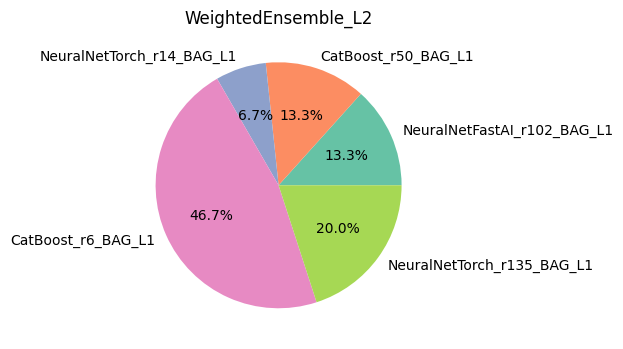

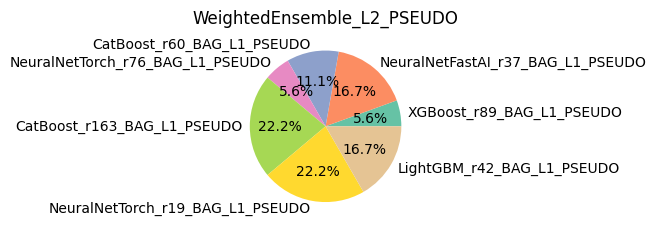

In [9]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [10]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.902516,roc_auc,0.646241,170.598345,0.001018,0.213627,2,True,111
1,WeightedEnsemble_L2_PSEUDO,0.902455,roc_auc,0.512682,189.700344,0.000748,0.210173,2,True,222
2,CatBoost_r6_BAG_L1,0.899394,roc_auc,0.023961,13.211181,0.023961,13.211181,1,True,85
3,CatBoost_r60_BAG_L1_PSEUDO,0.899276,roc_auc,0.016568,15.995564,0.016568,15.995564,1,True,191
4,CatBoost_r50_BAG_L1,0.899127,roc_auc,0.023611,13.182466,0.023611,13.182466,1,True,33
5,CatBoost_r163_BAG_L1_PSEUDO,0.898848,roc_auc,0.023426,13.853184,0.023426,13.853184,1,True,213
11,LightGBM_r42_BAG_L1_PSEUDO,0.898194,roc_auc,0.046325,13.544196,0.046325,13.544196,1,True,219
14,NeuralNetTorch_r76_BAG_L1_PSEUDO,0.897863,roc_auc,0.140632,47.800649,0.140632,47.800649,1,True,201
22,NeuralNetTorch_r19_BAG_L1_PSEUDO,0.897361,roc_auc,0.112556,43.391601,0.112556,43.391601,1,True,216
27,NeuralNetFastAI_r37_BAG_L1_PSEUDO,0.897075,roc_auc,0.112245,45.670127,0.112245,45.670127,1,True,164


# Collecting and saving OOF files

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
overall_scores = {}
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    overall_scores[model] = cv_score
    
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

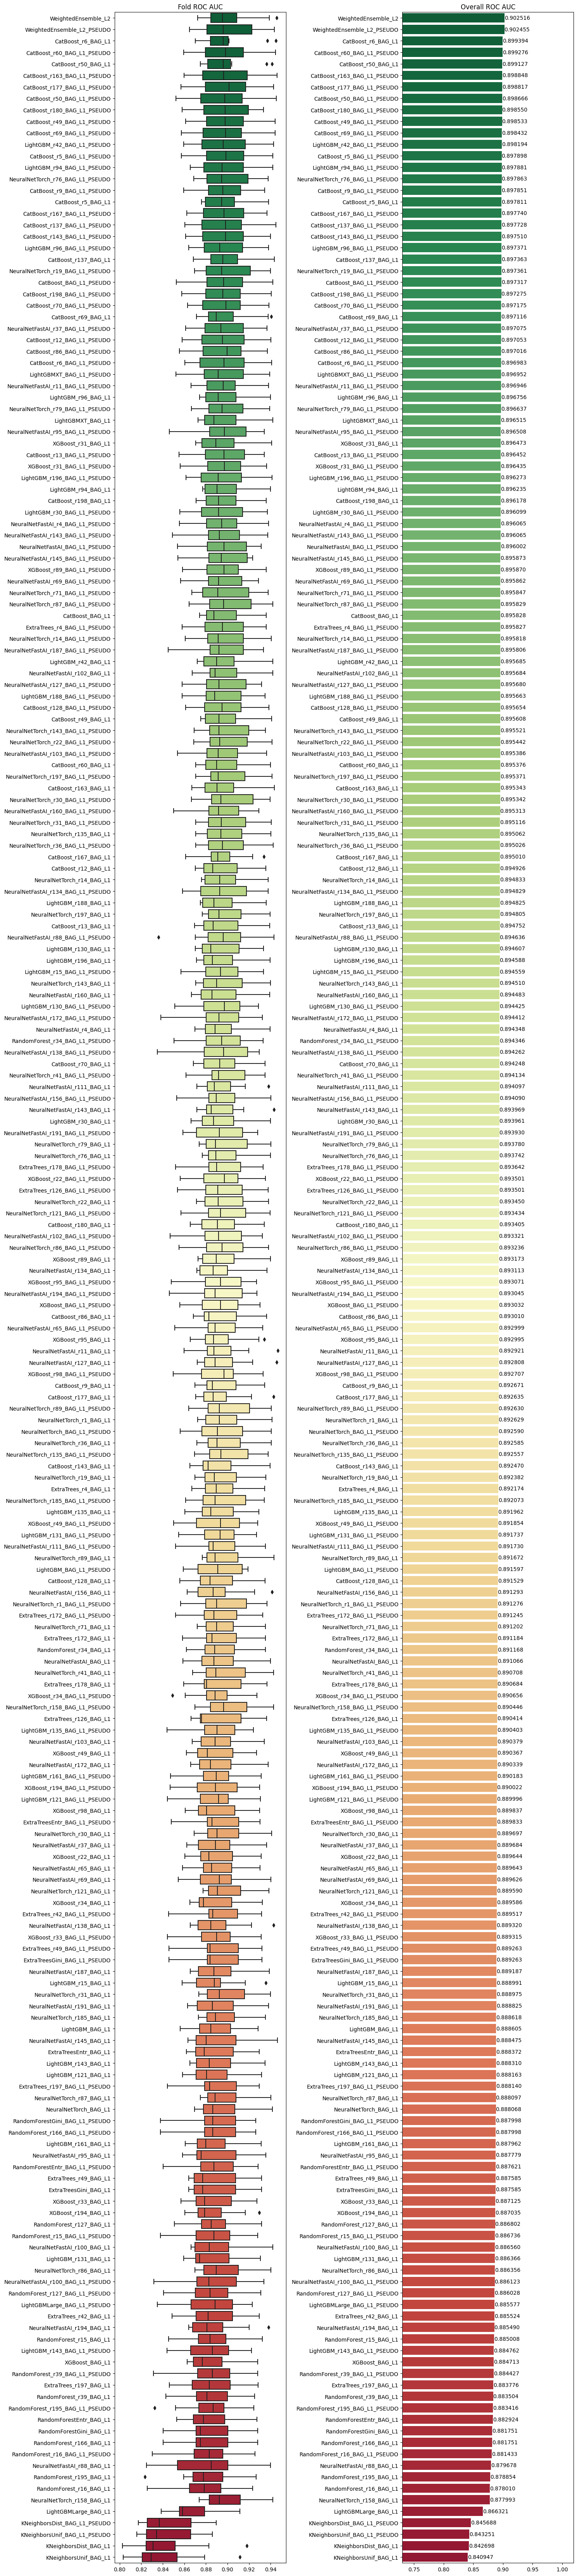

In [15]:
scores_df = pd.DataFrame(scores)
overall_scores_series = pd.Series({k: v for k, v in overall_scores.items()})
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = min(scores_df.min().min(), overall_scores_series.min())
max_score = max(scores_df.max().max(), overall_scores_series.max())
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores) * 0.3))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold ROC AUC")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall ROC AUC")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(overall_scores_series[order]):
    barplot.text(score, i, f"{score:.6f}", va="center")

plt.tight_layout()
plt.show()